# Water Clasification Random Forest CPU

Version: DEMO

ILAB Team

Kernel to use:
- (ADAPT PRISM) `Python [conda env:ilab]`

This is a demo notebook showcasing how the ILAB team uses sklearn capabilities to perform efficient CPU-based training of a Random Forest classifier algorithm. This notebook also demonstates how to use a raster as a test data-set for the trained model.

In [1]:
import csv
import datetime
import glob
import joblib
import numpy as np
import os
import pandas as pd
from pathlib import Path
import sys
from pprint import pprint
import time

# Scikit learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.inspection import permutation_importance

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

#GDAL Stuff
from osgeo import gdalconst
from osgeo import gdal

plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
DATA_TYPE = np.float32

In [3]:
v_names = ['sur_refl_b01_1','sur_refl_b02_1','sur_refl_b03_1',
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']

Add names from above to this list to drop them from training and testing.

For example:

```python
columnsToDrop = ['sur_refl_b01_1', 'sur_refl_b07_1', 'ndwi1']
```

In [4]:
columnsToDrop = []

This is a 1000 row training dataset which has columns for all the features listed in v_names. MODIS MOD09GA and MOD09GQ were the data sources.

In [5]:
dfPath = '../data/WaterClassificationPowell.parquet.gzip'

In [6]:
outputRasterPath = '.'

In [7]:
df = pd.read_parquet(dfPath).astype(DATA_TYPE)
df = df.drop(columns=columnsToDrop)
X = df.drop(['water'], axis=1)
y = df['water']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [8]:
kf = KFold(n_splits=5)
kf.get_n_splits(X_train)

5

## Data 
- Read in to cuDF Dataframe
- Drop unnecessary columns
- Split into Xs and Ys

## Load in data for use of visualizations 
(skip this if you just want to train model)

In [9]:
_ = [print(column) for column in X_train.columns]

sur_refl_b01_1
sur_refl_b02_1
sur_refl_b03_1
sur_refl_b04_1
sur_refl_b05_1
sur_refl_b06_1
sur_refl_b07_1
ndvi
ndwi1
ndwi2


In [10]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
sur_refl_b01_1,800.0,1258.096191,1340.759766,8.000000,235.750000,948.500000,1939.500000,9222.000000
sur_refl_b02_1,800.0,1635.454956,1598.351318,2.000000,172.750000,1489.500000,2717.500000,8837.000000
sur_refl_b03_1,800.0,770.067505,1065.750488,-100.000000,288.000000,568.500000,865.750000,8909.000000
sur_refl_b04_1,800.0,1062.625000,1122.454956,6.000000,413.000000,861.500000,1346.250000,9162.000000
sur_refl_b05_1,800.0,2023.324951,1481.220093,-92.000000,555.500000,1880.500000,3261.500000,6382.000000
sur_refl_b06_1,800.0,1982.285034,1553.377441,45.000000,511.250000,1630.000000,3303.000000,6610.000000
sur_refl_b07_1,800.0,1635.647461,1408.475098,1.000000,328.000000,1253.500000,2764.000000,6128.000000
ndvi,800.0,114.366447,2476.145996,-9493.670898,-1411.943359,761.689178,1738.830963,8587.457031
ndwi1,800.0,-2303.467773,3440.189453,-9727.272461,-4578.389038,-1572.635315,-778.649902,8823.803711
ndwi2,800.0,-911.150757,3839.955566,-9615.384766,-2856.181274,-695.494446,850.627075,9848.484375


## Random Forest Model

### Model Definition

In [11]:
hyperparameters = {
     'bootstrap': True,
     'ccp_alpha': 0.0,
     'class_weight': None,
     'criterion': 'gini',
     'max_depth': None,
     'max_features': 'auto',
     'max_leaf_nodes': None,
     'max_samples': None,
     'min_impurity_decrease': 0.0,
     'min_samples_leaf': 1,
     'min_samples_split': 2,
     'min_weight_fraction_leaf': 0.0,
     'n_estimators': 100,
     'n_jobs': None,
     'oob_score': False,
     'random_state': None,
     'verbose': 0,
     'warm_start': False}

In [12]:
classifier = RandomForestClassifier(**hyperparameters)

# Training

## K-Fold Cross Validation

In [13]:
%%time
bestModel = None
bestModelScore = 0
scores = []
for trainIdx, testIdx in kf.split(X_train):
    X_train_valid, X_test_valid = X_train.iloc[trainIdx], X_train.iloc[testIdx]
    y_train_valid, y_test_valid = y_train.iloc[trainIdx], y_train.iloc[testIdx]
    print('Fitting model')
    st = time.time()
    classifier.fit(X_train_valid, y_train_valid)
    et = time.time()
    print('Time to fit model: {}s'.format(et-st))
    print('Getting score')
    score = classifier.score(X_test_valid, y_test_valid)
    if score>=bestModelScore:
        bestModelScore = score
        print('Training accuracy score: {}'.format(score))
        bestModel = classifier
    print('Predicting for test set')
    test_predictions = classifier.predict(X_test)
    print(classification_report(y_test, test_predictions))
    print('Score: {}'.format(score))
    scores.append(score)
    del test_predictions, score

Fitting model
Time to fit model: 0.12104272842407227s
Getting score
Training accuracy score: 0.9875
Predicting for test set
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98        98
         1.0       0.97      0.99      0.98       102

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200

Score: 0.9875
Fitting model
Time to fit model: 0.11393141746520996s
Getting score
Predicting for test set
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98        98
         1.0       0.97      1.00      0.99       102

    accuracy                           0.98       200
   macro avg       0.99      0.98      0.98       200
weighted avg       0.99      0.98      0.98       200

Score: 0.975
Fitting model
Time to fit model: 0.11682486534118652s
Getting score
Predicting for test set
           

In [14]:
scoreAvg = np.asarray(scores).mean()
print('Average accuracy score: {}'.format(scoreAvg))
print('Best accuracy score: {}'.format(bestModelScore))

Average accuracy score: 0.9775
Best accuracy score: 0.9875


## Regular fitting

In [15]:
classifier = RandomForestClassifier(**hyperparameters)

In [16]:
%%time

classifier.fit(X_train, y_train)

CPU times: user 121 ms, sys: 6.93 ms, total: 128 ms
Wall time: 128 ms


RandomForestClassifier()

### Get model metrics

In [17]:
classifier = bestModel

In [18]:
score = classifier.score(X_test, y_test)
score = round(score, 3)
score

0.975

In [19]:
train_predictions = classifier.predict(X_train)
test_predictions = classifier.predict(X_test)
prediction_probs = classifier.predict_proba(X_test)

In [20]:
test_predictions = test_predictions.astype(np.int16)
y_test_int = y_test.astype(np.int16)

In [21]:
print('Train Performance')
print('-------------------------------------------------------')
print(classification_report(y_train, train_predictions))
print('Test Performance')
print('-------------------------------------------------------')
print(classification_report(y_test, test_predictions))
cm = confusion_matrix(y_test_int, test_predictions)
recall = (cm[0][0] / (cm[0][0] + cm[0][1]))
print('Test Recall')
print('-------------------------------------------------------')
print(recall)
print('Confusion Matrix')
print('-------------------------------------------------------')
print(cm)

Train Performance
-------------------------------------------------------
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00       402
         1.0       0.99      1.00      1.00       398

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800

Test Performance
-------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.96      0.97        98
         1.0       0.96      0.99      0.98       102

    accuracy                           0.97       200
   macro avg       0.98      0.97      0.97       200
weighted avg       0.98      0.97      0.97       200

Test Recall
-------------------------------------------------------
0.9591836734693877
Confusion Matrix
-------------------------------------------------------
[[ 94   4]
 [  1 101]]


In [22]:
%%time
permutation_importance_results = permutation_importance(classifier,
                                                        X=X_test,
                                                        y=y_test,
                                                        n_repeats=10,
                                                        random_state=42)

CPU times: user 783 ms, sys: 5.49 ms, total: 788 ms
Wall time: 791 ms


Text(0.5, 0, 'Permutation Importance')

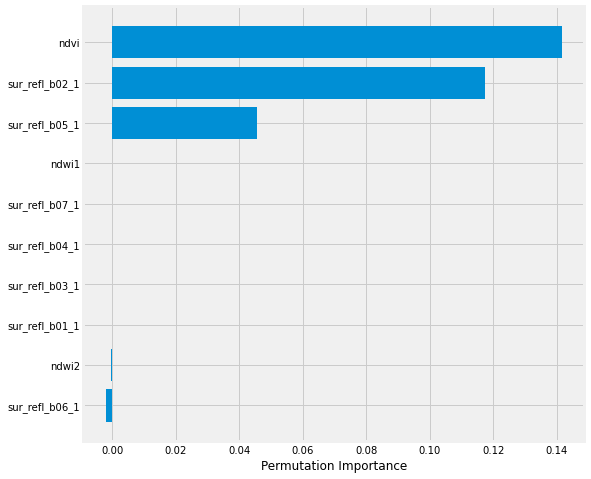

In [23]:
sorted_idx = permutation_importance_results.importances_mean.argsort()
plt.figure(figsize=(8, 8))
plt.barh(X_test.columns[sorted_idx], permutation_importance_results.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

In [24]:
del X_train, X_test, y_train, y_test, test_predictions, train_predictions, prediction_probs, y_test_int

## Save the model for future use

In [25]:
model_save_path = './water_classifier_rf_gpu.sav'
print('Saving model to: {}'.format(model_save_path))
print(classifier)
joblib.dump(classifier, model_save_path, compress=3)

Saving model to: ./water_classifier_rf_gpu.sav
RandomForestClassifier()


['./water_classifier_rf_gpu.sav']

# Testing: Raster testing

### Read in data 

These are modified MOD09GA and MOD09GQ products for the 2001 julian day 155. They were modified to be clipped to the Lake Powell region.

In [26]:
fileList = sorted([file for file in glob.glob('../data/IL.*.Powell.*.tif') if 'sur_refl' in file])

In [27]:
def readRastersToArray(fileList):
    rasterProjection = None
    newshp = (1300*1300, 10)
    img = np.empty(newshp, dtype=np.int16)
    for i, fileName in enumerate(fileList):
        ds = gdal.Open(fileName)
        img[:, i] = ds.GetRasterBand(1).ReadAsArray().astype(np.int16).ravel()
        if i == 0:
            rasterProjection = ds.GetProjection()
        ds = None
    img[:, len(fileList)] = ((img[:, 1] - img[:, 0]) / (img[:, 1] + img[:, 0])) * 10000
    img[:, len(fileList)+1] = ((img[:, 1] - img[:, 5]) / (img[:, 1] + img[:, 5])) * 10000
    img[:, len(fileList)+2] = ((img[:, 1] - img[:, 6]) / (img[:, 1] + img[:, 6])) * 10000
    return img, rasterProjection

In [28]:
%%time
im, rasterProjection = readRastersToArray(fileList)
print('Raster as ndarray')
print(im)
print('{} MB size'.format((im.size * im.itemsize) / 1000000))

Raster as ndarray
[[ 1547  2461   857 ...  2280  -518   510]
 [ 1474  2377   857 ...  2344  -691   337]
 [ 1474  2377   846 ...  2344  -472   623]
 ...
 [ 2358  2979  1028 ...  1163 -1727 -1292]
 [ 2425  3069  1117 ...  1172 -1721 -1216]
 [ 2402  3038  1117 ...  1169 -1770 -1266]]
33.8 MB size
CPU times: user 247 ms, sys: 27.1 ms, total: 274 ms
Wall time: 434 ms


### Load in the model

In [29]:
def predictRaster(img_chunk, colsToDrop=None):
    """
    Function given a raster in the form of a nxn matrix, will
    convert the matrix to a GPU-bound data frame then perform 
    predictions given the loaded model.
    
    Return the prediction matrix, the prediction probabilities
    for each and the dataframe converted to host.
    """
    print('Converting host array to CPU-based dataframe')
    df = pd.DataFrame(img_chunk, columns=v_names, dtype=np.float32)
    df = df.drop(columns=columnsToDrop)
    print('Making predictions from raster')
    predictions = classifier.predict(df)
    predictionsProbs = classifier.predict_proba(df)
    return predictions, predictionsProbs, df

In [30]:
%%time
predictedRaster, predictedProbaRaster, df = predictRaster(im)

Converting host array to CPU-based dataframe
Making predictions from raster
CPU times: user 10.3 s, sys: 87.5 ms, total: 10.4 s
Wall time: 10.4 s


### Description of the predicted probability for each pixel in the raster (no bad-data vals masked yet)

In [31]:
shp = (1300, 1300)
left = list()
right = list()
for i, subarr in enumerate(predictedProbaRaster):
    left.append(subarr[0])
    right.append(subarr[1])
leftArr = np.asarray(left)
rightArr = np.asarray(right)
probaLand = leftArr.reshape(shp)
probaWater = rightArr.reshape(shp)

#### Reshape the unravelled matrix back to the 4800x4800 raster shape

In [32]:
shp = (1300, 1300)
matrix = np.asarray(predictedRaster)
reshp = matrix.reshape(shp)
reshp.shape

(1300, 1300)

Add QA mask to prediction

In [33]:
qa = [file for file in glob.glob('../data/*.tif') if 'qa' in file][0]
ds = gdal.Open(qa)
qaMask = ds.GetRasterBand(1).ReadAsArray()
output = np.where(qaMask == 0, reshp, -9999)
qaMask

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

In [34]:
countNoData = np.count_nonzero(output == -9999)
countLand = np.count_nonzero(output == 0)
countWater = np.count_nonzero(output == 1)
print('Predicted\n No-data occuraces: {}\n Land occurances: {}\n Water occurances: {}'.format(countNoData, countLand, countWater))

Predicted
 No-data occuraces: 61568
 Land occurances: 1616625
 Water occurances: 11807


## Output predicted raster to GeoTiff

In [35]:
geoTransform = (-9961223.407, 231.65635, 0.0, 4285642.633667, 0.0, -231.65635)

In [36]:
predictedPath = os.path.join(outputRasterPath, 'PowellPredictedWaterMask.tif')

driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(predictedPath, 1300, 1300, 1, gdal.GDT_Int16, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geoTransform)
outDs.SetProjection(rasterProjection)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(output)
outBand.SetNoDataValue(-9999)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

## View predictions with Folium

In [37]:
import folium
from folium import plugins

sys.path.append('../scripts')
import folium_helper

In [38]:
mask_3857 = folium_helper.reproject_to_3857(predictedPath)
mask_d = folium_helper.get_bounds(mask_3857)
mask_b1 = folium_helper.open_and_get_band(mask_3857, 1)
folium_helper.cleanup(mask_3857)
mask_b1 = np.where(mask_b1 == -9999, 0, mask_b1)
zeros = np.zeros_like(mask_b1)
mask_rgb = np.dstack((mask_b1, zeros, zeros))

Transform: | 491.82, 0.00,-12749861.52|
| 0.00,-491.82, 4656230.30|
| 0.00, 0.00, 1.00|
Width: 1670 Height: 770


In [39]:
m = folium.Map(location=[mask_d['center'][1], mask_d['center'][0]],
                   tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', zoom_start = 6, attr='Google')

In [40]:
m.add_child(folium_helper.get_overlay(mask_rgb, mask_d, 'Water classification XGBOOST predicted mask', opacity=0.6))
m.add_child(plugins.MousePosition())
m.add_child(folium.LayerControl())